In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from pydgrid.plot_bokeh import plot_results
import sympy as sym
import pydae.build as db
import pydae.build_cffi as db

from pydae.grid_urisi import unb_ri_si
import json
import networkx as nx
import time

In [2]:
grid = unb_ri_si('cigre_eu_lv_acdc.json')

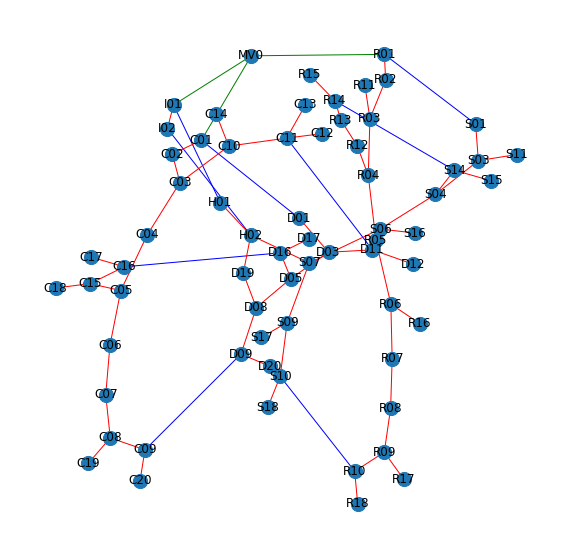

In [3]:
with open('cigre_eu_lv_acdc.json','r') as fobj:
    data = json.loads(fobj.read().replace("'",'"'))
    
G = nx.Graph()

for bus in data['buses']:
    G.add_node(bus['bus'])  # default edge data=1
    
for line in data['lines']:
    G.add_edge(line['bus_j'], line['bus_k'],color='r',weight=10)  # default edge data=1
for trafo in data['transformers']:
    G.add_edge(trafo['bus_j'], trafo['bus_k'],color='g')  # default edge data=1
for vsc in data['vscs']:
    G.add_edge(vsc['bus_ac'], vsc['bus_dc'],color='b')  # default edge data=1
        
colors = nx.get_edge_attributes(G,'color').values()
        
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),sharex=True)

nx.draw(G,pos=nx.spring_layout(G),node_size=200, edge_color=colors,with_labels=True)   # default spring_layout
#subax2 = plt.subplot(122)
#nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

In [4]:
nx.is_connected(G)
colors = nx.get_edge_attributes(G,'color').values()
colors

dict_values(['g', 'g', 'g', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'b', 'r', 'b', 'b', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'b', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r'])

In [5]:

params_dict  = grid.dae['params']
f_list = grid.dae['f']
x_list = grid.dae['x']
g_list = grid.dae['g'] 
y_list = grid.dae['y'] 
u_dict = grid.dae['u']


h_dict = grid.dae['h_dict']
h_dict.update(grid.dae['h_v_m_dict'])

sys_dict = {'name':'cigre_eu_lv_acdc',
           'params_dict':params_dict,
           'f_list':f_list,
           'g_list':g_list,
           'x_list':x_list,
           'y_ini_list':y_list,
           'y_run_list':y_list,
           'u_run_dict':u_dict,
           'u_ini_dict':u_dict,
           'h_dict':h_dict
           }

db.build(sys_dict,verbose=True);



check_system (time: 0.0)
system without dynamic equations, adding dummy dynamic equation
computing jacobians Fx_run,Fy_run  (time: 0.883 s)
computing jacobians Gx_run,Gy_run  (time: 0.943 s)
computing jacobians Fu_run,Gu_run  (time: 42.938 s)
computing jacobians Fx_ini,Fy_ini  (time: 60.259 s)
computing jacobians Gx_ini,Gy_ini  (time: 60.320 s)
computing jacobians Hx_run,Hy_run,Hu_run  (time: 101.67906165122986 s)
end system  (time: 153.675 s)
computing jac_ini (time: 0.0)
computing jac_run (time: 0.79581618309021)
computing jac_trap (time: 1.6405563354492188)
end of jacobians computation (time: 2.409)
writting f_ini and g_ini code (time: 0.000 s)
writting f_run and g_run code (time: 33.599 s)
writting h_run code (time: 87.116 s)
converting jac_ini to sp_jac_ini  (time: 126.908 s)
running sym2rhs for sp_jac_ini (time: 127.048 s)
converting jac_run to sp_jac_run  (time: 143.298 s)
running sym2rhs for sp_jac_run (time: 143.445 s)
converting jac_trap to sp_jac_trap  (time: 159.824 s)
runn

In [6]:
N_y = len(sys_dict['g'])
G_y = sym.zeros(N_y)
t_0 = time.time()

for irow in range(N_y):
    str_g =  str(sys_dict['g'][irow])
    for icol in range(N_y):
        if str(sys_dict['y_ini'][icol]) in str_g:
            G_y[irow,icol] = sys_dict['g'][irow].diff(sys_dict['y_ini'][icol]);
print(time.time() - t_0)

56.493080615997314


## Experimental initial conditions

In [12]:
delta = np.deg2rad(30)
for item in grid.dae['xy_0_dict']:
    ph = item.split('_')[2]
    ir = item.split('_')[3]
    if ph == 'a':
        v = 400.0/np.sqrt(3)*np.exp(1j*0.0+delta)
        if ir == 'r':
            grid.dae['xy_0_dict'][item] = v.real
        if ir == 'i':
            grid.dae['xy_0_dict'][item] = v.imag
    if ph == 'b':
        v = 400.0/np.sqrt(3)*np.exp(1j*(-2/3*np.pi+delta))
        if ir == 'r':
            grid.dae['xy_0_dict'][item] = v.real
        if ir == 'i':
            grid.dae['xy_0_dict'][item] = v.imag  
    if ph == 'c':
        v = 400.0/np.sqrt(3)*np.exp(1j*(-4/3*np.pi+delta))
        if ir == 'r':
            grid.dae['xy_0_dict'][item] = v.real
        if ir == 'i':
            grid.dae['xy_0_dict'][item] = v.imag 

data = json.dumps(grid.dae['xy_0_dict'], indent=4)
fobj = open("xy_0_dict.json","w")
fobj.write(data)
fobj.close()            

In [ ]:
grid.dae['xy_0_dict']

In [ ]:
import pydgrid

In [ ]:
grid = pydgrid.grid()
grid.read('cigre_eu_lv.json')
grid.pf()
grid.buses

In [ ]:
grid = unb_ri_si('cigre_eu_lv_reduced.json')

params_dict  = grid.dae['params']
f_list = grid.dae['f']
x_list = grid.dae['x']
g_list = grid.dae['g'] 
y_list = grid.dae['y'] 
u_dict = grid.dae['u']


h_dict = grid.dae['h_dict']
h_dict.update(grid.dae['h_v_m_dict'])

sys_dict = {'name':'cigre_eu_lv_reduced',
           'params_dict':params_dict,
           'f_list':f_list,
           'g_list':g_list,
           'x_list':x_list,
           'y_ini_list':y_list,
           'y_run_list':y_list,
           'u_run_dict':u_dict,
           'u_ini_dict':u_dict,
           'h_dict':h_dict
           }

db.build(sys_dict,verbose=True)

In [ ]:
with open('cigre_eu_lv_acdc.json','r') as fobj:
    data = json.loads(fobj.read().replace("'",'"'))

In [ ]:
data

In [21]:
from networkx.algorithms.dag import transitive_closure

def dependency_graph(G, nodes):
    return transitive_closure(G).subgraph(nodes)

G = nx.Graph() 
G.add_edges_from([(1,3),(3,4),(1,5),(5,6),(2,6),(4,6)])

print(dependency_graph(G, [1, 2, 4, 6]).edges)

NetworkXNotImplemented: not implemented for undirected type

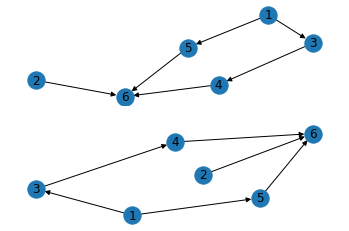

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph() 
G.add_edges_from([(1,3),(3,4),(1,5),(5,6),(2,6),(4,6)])

threshold = 2
#G_s  = G.subgraph([node for node in G.nodes() if G.degree(node) != threshold])

G_s, c_nodes = nx.dedensify(G, threshold=threshold)

fig, ax = plt.subplots(2, 1)

nx.draw(  G, ax = ax[0], with_labels = 1)
nx.draw(G_s, ax = ax[1], with_labels = 1)

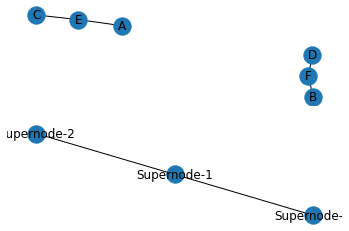

In [30]:
nodes = {
    "A": dict(color="Red"),
    "B": dict(color="Red"),
    "C": dict(color="Red"),
    "D": dict(color="Red"),
    "E": dict(color="Blue"),
    "F": dict(color="Blue"),
}
edges = [
    ("A", "E", "Strong"),
    ("B", "F", "Strong"),
    ("C", "E", "Weak"),
    ("D", "F", "Weak"),
]
G = nx.Graph()
for node in nodes:
    attributes = nodes[node]
    G.add_node(node, **attributes)

for source, target, type in edges:
    G.add_edge(source, target, type=type)

node_attributes = ('color', )
edge_attributes = ('type', )
G_s = nx.snap_aggregation(G, node_attributes=node_attributes, edge_attributes=edge_attributes)

fig, ax = plt.subplots(2, 1)

nx.draw(  G, ax = ax[0], with_labels = 1)
nx.draw(G_s, ax = ax[1], with_labels = 1)

In [34]:
G_s.edges.data()

EdgeDataView([('Supernode-0', 'Supernode-1', {'types': [{'type': 'Strong'}]}), ('Supernode-1', 'Supernode-2', {'types': [{'type': 'Weak'}]})])

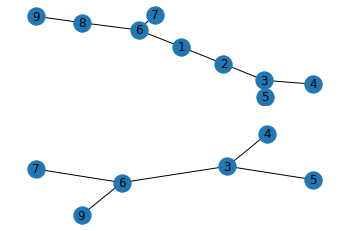

In [42]:
l = [('1','2'),('2','3'),('3','4'),('3','5'),('1','6'),('6','7'),('6','8'),('9','8')]

G=nx.Graph()

G.add_edges_from(l)
G_s = G.copy()


# Select all nodes with only 2 neighbors
nodes_to_remove = [n for n in G.nodes if len(list(G.neighbors(n))) == 2]

# For each of those nodes
for node in nodes_to_remove:
    # We add an edge between neighbors (len == 2 so it is correct)
    G_s.add_edge(*G_s.neighbors(node))
    # And delete the node
    G_s.remove_node(node)

fig, ax = plt.subplots(2, 1)

nx.draw(G,ax = ax[0],with_labels=True)
nx.draw(G_s,ax = ax[1],with_labels=True)
